In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from LSTM_demo import LSTM
import torch
import torch.nn as nn

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\asus\AppData\Local\Temp\ipykernel_1676\308558919.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Preprocessing

In [2]:
# top 7 MarketCap in S&P500(^GSPC)
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']

df_close = pd.DataFrame()

for ticker in tickers:
    data = pd.read_csv(f'data/{ticker}.csv', index_col="Date", parse_dates=True)
    
    close_prices = data['Close'].rename(ticker + "_close")
    
    df_close = pd.concat([df_close, close_prices], axis=1)

df_close.dropna(inplace=True)

In [3]:
df_log_return = pd.DataFrame()

for name in df_close.columns:
  col_name = name[:-6] + "_log_return"
  df_log_return[col_name] = np.log(df_close[name]).diff()
  
df_log_return['^GSPC_log_return'] = df_log_return['^GSPC_log_return'].shift(-1)
df_log_return['^GSPC_log_return'].tail()

2024-04-09 00:00:00   -0.009502
2024-04-10 00:00:00    0.007417
2024-04-11 00:00:00   -0.014658
2024-04-12 00:00:00    0.001001
2024-04-15 00:00:00         NaN
Name: ^GSPC_log_return, dtype: float64

In [4]:
df_log_return

,^GSPC_log_return,AAPL_log_return,MSFT_log_return,AMZN_log_return,NVDA_log_return,GOOGL_log_return,TSLA_log_return,META_log_return
2012-05-18 00:00:00,0.015909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21 00:00:00,0.000486,0.056626,0.016266,0.019725,0.017235,0.022578,0.042968,-0.116378
2012-05-22 00:00:00,0.001692,-0.007708,0.000336,-0.012828,-0.012280,-0.021912,0.068181,-0.093255
2012-05-23 00:00:00,0.001379,0.024107,-0.022083,0.009015,0.024411,0.014311,0.007118,0.031749
2012-05-24 00:00:00,-0.002168,-0.009226,-0.001375,-0.009433,-0.026886,-0.009562,-0.024145,0.031680
...,...,...,...,...,...,...,...,...
2024-04-09 00:00:00,-0.009502,0.007216,0.003972,0.002589,-0.020628,0.011238,0.022296,-0.004536
2024-04-10 00:00:00,0.007417,-0.011202,-0.007110,0.001507,0.019549,-0.002942,-0.029373,0.005652
2024-04-11 00:00:00,-0.014658,0.042361,0.010973,0.016534,0.040274,0.020726,0.016400,0.006385
2024-04-12 00:00:00,0.001001,0.008590,-0.014191,-0.015566,-0.027183,-0.010595,-0.020542,-0.021758


# Model

In [5]:
df_to_model = df_log_return

In [6]:
Ntest = 1000
df_train = df_to_model.iloc[1:-Ntest]
df_test = df_to_model.iloc[-Ntest:-1]

X_train = df_train.drop(columns=['^GSPC_log_return'])
X_test = df_test.drop(columns=['^GSPC_log_return'])

y_train = df_train['^GSPC_log_return']
y_test = df_test['^GSPC_log_return']

## Train Model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
naive_model = None
linear_model = LinearRegression()
# logistic_model = LogisticRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
lstm_model = LSTM()

models = {
    'NaiveForecast': naive_model,
    'LinearRegression': linear_model,
    # 'LogisticRegression': logistic_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    'LSTM': lstm_model
}

In [18]:
results = {}

for name, model in models.items():
    print("Training : ", name)

    if name == 'NaiveForecast':
        y_pred_test = y_test.shift(1).fillna(y_test.iloc[0]) # Backward Filling
        y_pred_train = y_train.shift(1).fillna(y_train.iloc[0])
    elif name == 'LSTM':
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        epochs = 30

        model.to(device)
        model.train()
        
        for i in range(epochs):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X[:,:,None].to(device)
                batch_y = batch_y[:,None].to(device)

                optimizer.zero_grad()
                model.reset_hidden_state()
                y_pred = model(batch_X)

                loss = loss_function(y_pred, batch_y)
                loss.backward()
                optimizer.step()

                total_loss += loss.to(torch.device('cpu')).item()

            if i % 5 == 1:
                print(f'epoch: {i:3} loss: {total_loss/len(train_loader):10.8f}')

        model.eval()

        with torch.no_grad():
            # y_pred_train = model(X_train_tensor).numpy()
            X_test_tensor = X_test_tensor[:,:,None].to(device)
            y_pred_test = model(X_test_tensor)
            y_pred_test = y_pred_test.to(torch.device('cpu')).numpy().reshape(-1)
    else:
        if name == 'LogisticRegression':
            y_train_bool = (y_train > 0) # Continuos -> Discrete(bool)
            model.fit(X_train, y_train_bool)
        else:
            model.fit(X_train, y_train)
        
        # y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = np.mean(np.sign(y_pred_test) == np.sign(y_test))
    
    
    results[name] = {
        'model': model,
        # 'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training :  NaiveForecast
Training :  LinearRegression
Training :  SVR
Training :  RFR
Training :  LSTM
epoch:   1 loss: 0.00011620
epoch:   6 loss: 0.00012036
epoch:  11 loss: 0.00012206
epoch:  16 loss: 0.00011276
epoch:  21 loss: 0.00011612
epoch:  26 loss: 0.00011236


Model: NaiveForecast
MAE: 0.0119
MSE: 0.0003
RMSE: 0.0159
direction: 0.4815


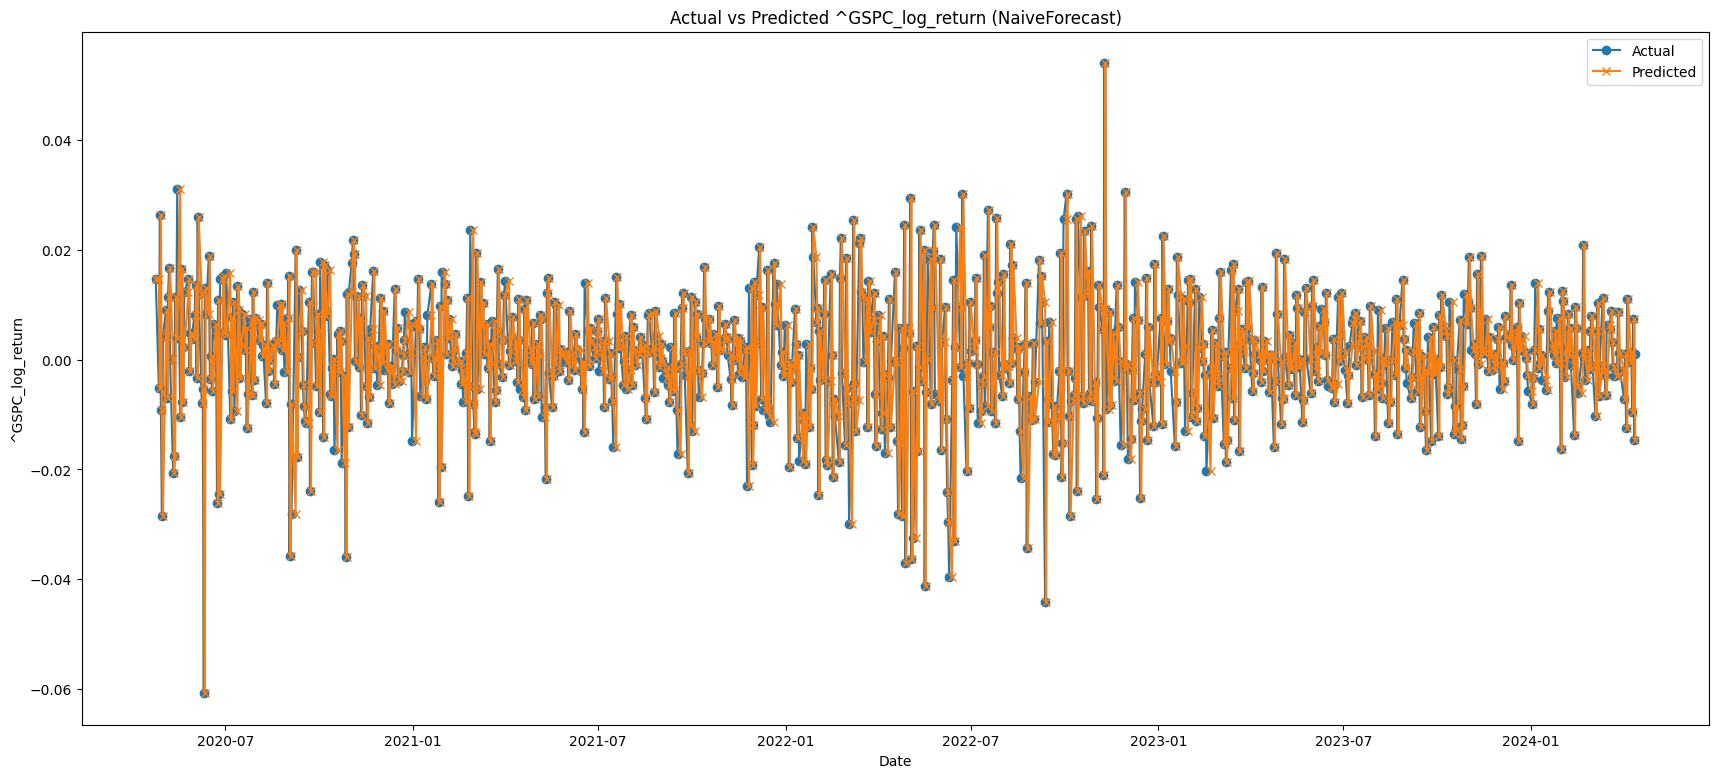

Model: LinearRegression
MAE: 0.0083
MSE: 0.0001
RMSE: 0.0112
direction: 0.5295


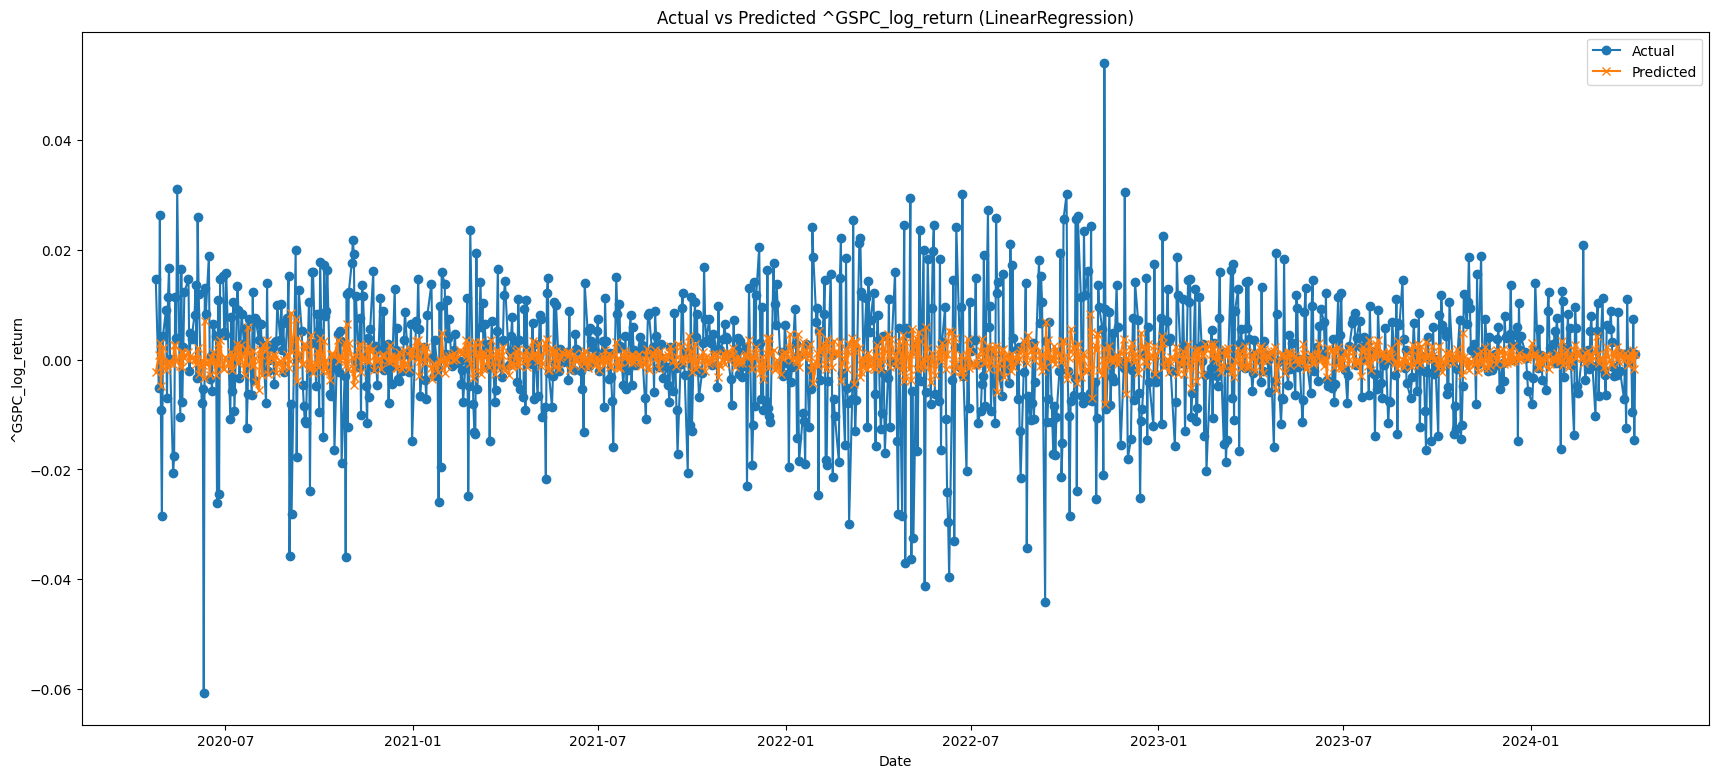

Model: SVR
MAE: 0.0169
MSE: 0.0004
RMSE: 0.0192
direction: 0.4675


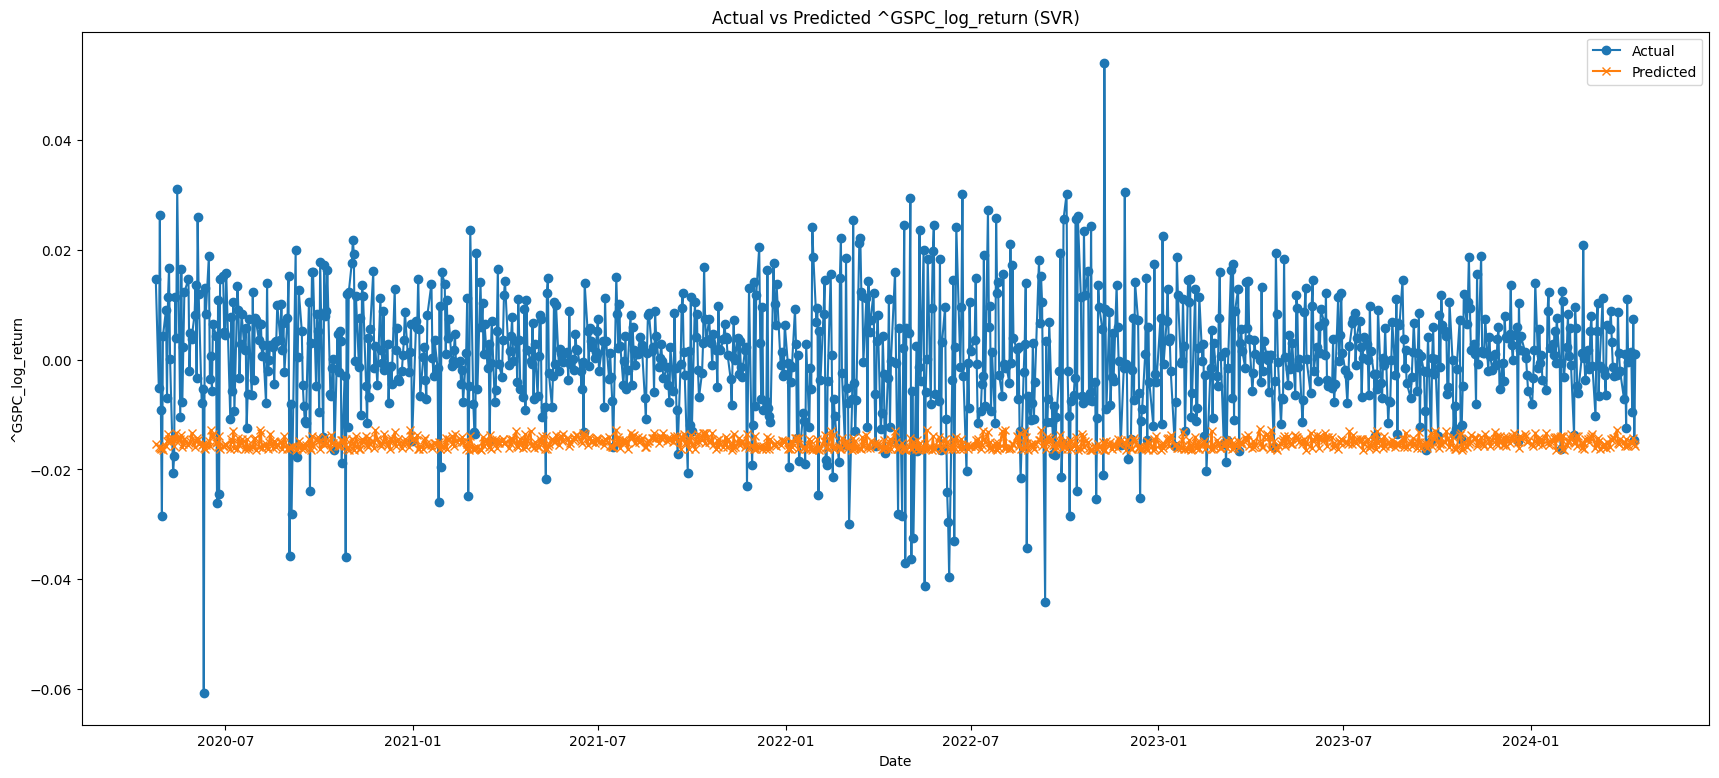

Model: RFR
MAE: 0.0088
MSE: 0.0001
RMSE: 0.0117
direction: 0.4865


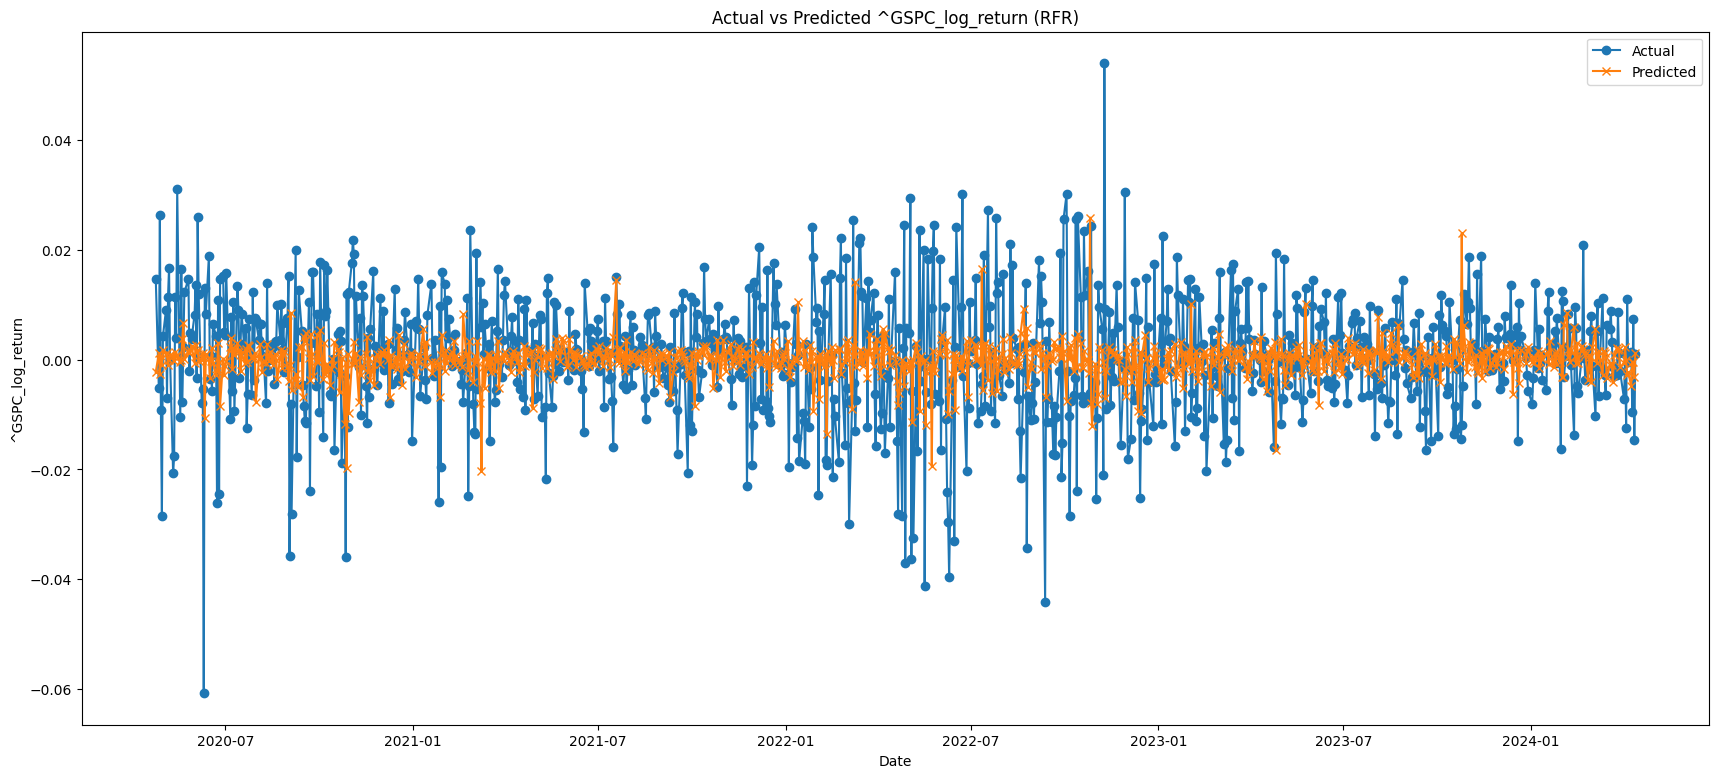

Model: LSTM
MAE: 0.0089
MSE: 0.0001
RMSE: 0.0116
direction: 0.5135


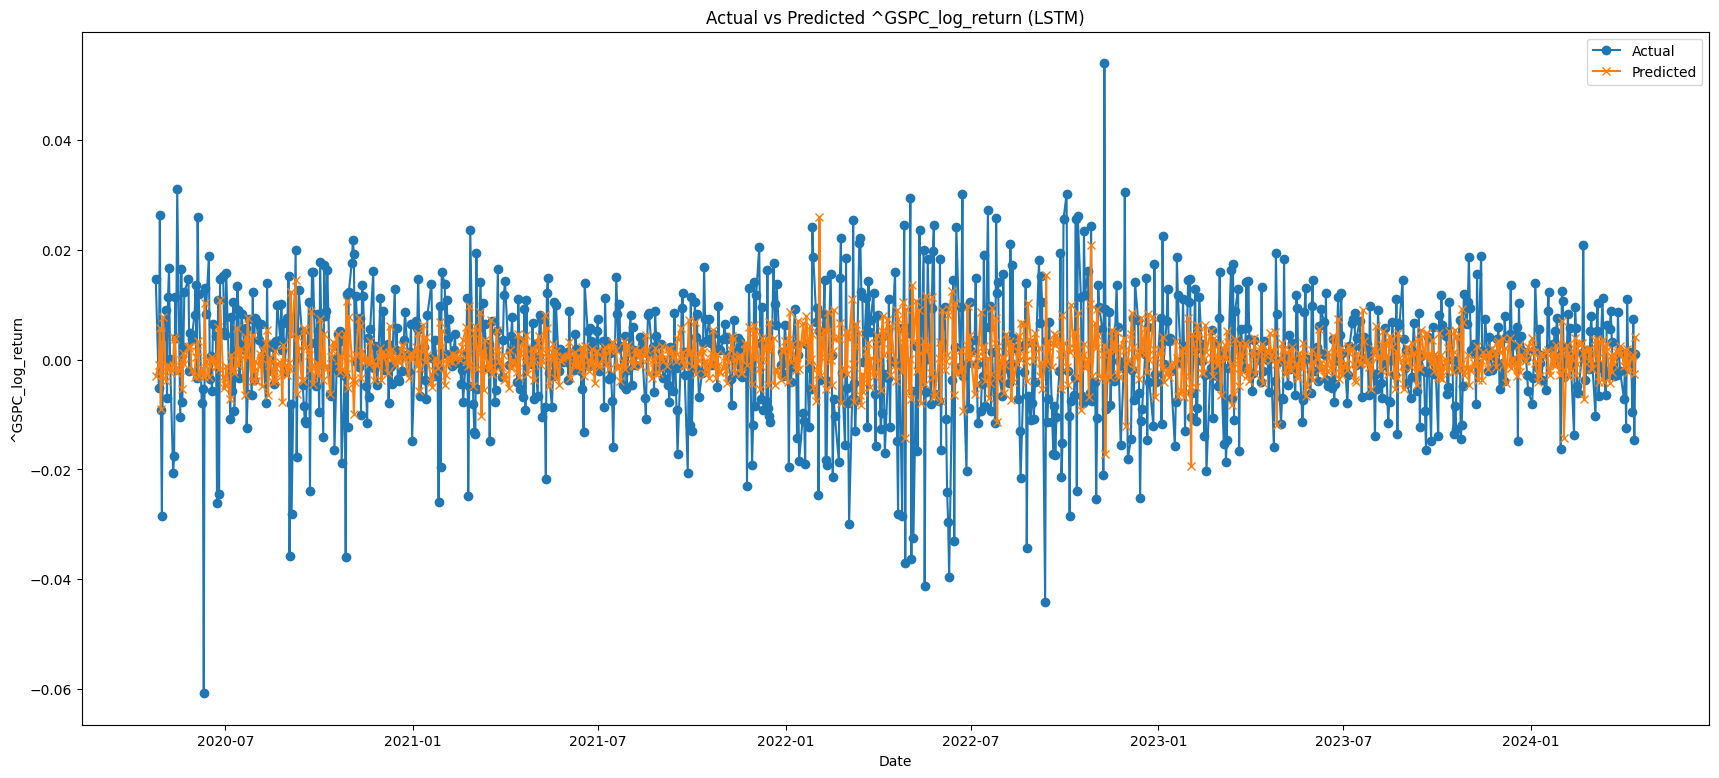

In [19]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"direction: {metrics['direction']:.4f}")
    
    plt.figure(figsize=(21, 9))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, metrics['y_pred_test'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('^GSPC_log_return')
    plt.title(f'Actual vs Predicted ^GSPC_log_return ({name})')
    plt.legend()
    plt.show()

In [20]:
results

{'NaiveForecast': {'model': None,
  'y_pred_test': 2020-04-24    0.014607
  2020-04-27    0.014607
  2020-04-28   -0.005256
  2020-04-29    0.026237
  2020-04-30   -0.009255
                  ...   
  2024-04-08   -0.000375
  2024-04-09    0.001444
  2024-04-10   -0.009502
  2024-04-11    0.007417
  2024-04-12   -0.014658
  Name: ^GSPC_log_return, Length: 999, dtype: float64,
  'mae': 0.011856222526363935,
  'mse': 0.0002519024151451485,
  'rmse': 0.015871433934750462,
  'direction': 0.48148148148148145},
 'LinearRegression': {'model': LinearRegression(),
  'y_pred_test': array([-2.32967590e-03,  8.84907297e-04,  3.01146377e-03, -4.78825214e-03,
         -1.21992115e-03,  2.02914273e-03, -1.94350741e-03, -1.13207542e-03,
         -5.58533761e-04, -2.88546346e-04, -6.46952827e-04, -7.94866504e-04,
          2.56267435e-03,  2.60018742e-03,  1.80496680e-04, -1.57668008e-04,
         -1.08518013e-03,  1.45554149e-03, -1.27565199e-03,  1.36589554e-03,
          2.25641764e-04,  1.42249110e